In [1]:
import pandas as pd
import glob 

In [2]:
paths = glob.glob("C:/Users/Dev/Documents/cbm_codes_open-master/featurematrix/feature_matrix_energy8_1024*.csv")
print(paths)

['C:/Users/Dev/Documents/cbm_codes_open-master/featurematrix\\feature_matrix_energy8_1024_ball.csv', 'C:/Users/Dev/Documents/cbm_codes_open-master/featurematrix\\feature_matrix_energy8_1024_inner.csv', 'C:/Users/Dev/Documents/cbm_codes_open-master/featurematrix\\feature_matrix_energy8_1024_outer_6.csv']


In [3]:
df1 = pd.read_csv(paths[0])
df1.loc[1657:,'fault_type'] = "ball"
# df1['fault_type'].value_counts()
df2 = pd.read_csv(paths[1])
df2.loc[1657:,'fault_type'] = 'inner'
data_all = df1.append(df2[1657:], ignore_index = True)
df3 = pd.read_csv(paths[2])
df3.loc[1657:,'fault_type'] = 'outer'
data_all = data_all.append(df3[1657:], ignore_index = True)
del [df1, df2, df3]
data_all['fault_type'].value_counts()

C:\Users\Dev\AppData\Local\Temp\ipykernel_15388\4270435050.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = df1.append(df2[1657:], ignore_index = True)
C:\Users\Dev\AppData\Local\Temp\ipykernel_15388\4270435050.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = data_all.append(df3[1657:], ignore_index = True)


ball      1894
inner     1893
Normal    1657
outer     1425
Name: fault_type, dtype: int64

In [4]:
import numpy as np
from numpy.random import choice 
np.random.seed(1)
index = np.array([choice(np.arange(0,1657),1400,replace = False),
                choice(np.arange(1657,3551),1400,replace = False),
                choice(np.arange(3551,5444),1400,replace = False),
                choice(np.arange(5444,6869),1400,replace = False)])
index = index.ravel()
data = data_all.iloc[index,]
data = data.reset_index(drop = True)
test_index = np.array([choice(np.arange(0,1400),400, replace = False),
                     choice(np.arange(1400,2*1400),400, replace = False),
                     choice(np.arange(2*1400,3*1400),400, replace = False),
                     choice(np.arange(3*1400,4*1400),400, replace = False)])

test_index = test_index.ravel()
test_data = data.iloc[test_index,]
train_data = data.drop(data.index[test_index])

# Shuffle data
train_data = train_data.sample(frac = 1, random_state = 2)
test_data = test_data.sample(frac = 1, random_state = 3)

# Convert categorical lables to numberic entries

category_labels = ['Normal', 'ball', 'inner','outer']
# test_labels = test_data['fault_type']
test_labels = pd.Categorical(test_data['fault_type'],categories= category_labels).codes # Produces ndarrays
# train_labels = train_data['fault_type']
train_labels = pd.Categorical(train_data['fault_type'], categories = category_labels).codes

In [5]:
print(data.shape,test_data.shape,train_data.shape,test_labels.shape,train_labels.shape)

(5600, 9) (1600, 9) (4000, 9) (1600,) (4000,)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
from sklearn import preprocessing

In [7]:
# Convert labels to categorical data
train_data = train_data.iloc[:,0:8]
test_data = test_data.iloc[:,0:8]
# Scale the data
train_data = preprocessing.scale(train_data)
test_data = preprocessing.scale(test_data)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(4000, 8) (1600, 8) (4000, 4) (1600, 4)


In [9]:
model = Sequential([
    layers.Dense(5,activation = 'relu', input_dim = 8),
#     layers.Dropout(0.2),
    layers.Dense(5,activation = 'relu'),
    layers.Dense(4,activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 45        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 4)                 24        
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)]

In [12]:
history = model.fit(train_data,train_labels,epochs = 100, validation_split = 0.2, verbose = 2, callbacks = callbacks)

Epoch 1/100
100/100 - 1s - loss: 1.3613 - accuracy: 0.2172 - val_loss: 1.2864 - val_accuracy: 0.2138 - 1s/epoch - 13ms/step
Epoch 2/100
100/100 - 0s - loss: 1.2432 - accuracy: 0.4419 - val_loss: 1.1937 - val_accuracy: 0.4663 - 168ms/epoch - 2ms/step
Epoch 3/100
100/100 - 0s - loss: 1.1447 - accuracy: 0.4919 - val_loss: 1.0987 - val_accuracy: 0.5013 - 166ms/epoch - 2ms/step
Epoch 4/100
100/100 - 0s - loss: 1.0522 - accuracy: 0.5125 - val_loss: 1.0221 - val_accuracy: 0.4913 - 166ms/epoch - 2ms/step
Epoch 5/100
100/100 - 0s - loss: 0.9799 - accuracy: 0.5022 - val_loss: 0.9619 - val_accuracy: 0.4850 - 166ms/epoch - 2ms/step
Epoch 6/100
100/100 - 0s - loss: 0.9232 - accuracy: 0.5138 - val_loss: 0.9112 - val_accuracy: 0.4875 - 172ms/epoch - 2ms/step
Epoch 7/100
100/100 - 0s - loss: 0.8730 - accuracy: 0.4691 - val_loss: 0.8640 - val_accuracy: 0.4925 - 168ms/epoch - 2ms/step
Epoch 8/100
100/100 - 0s - loss: 0.8278 - accuracy: 0.4978 - val_loss: 0.8217 - val_accuracy: 0.4675 - 169ms/epoch - 2ms

Epoch 66/100
100/100 - 0s - loss: 0.2076 - accuracy: 0.9556 - val_loss: 0.2319 - val_accuracy: 0.9513 - 174ms/epoch - 2ms/step
Epoch 67/100
100/100 - 0s - loss: 0.2046 - accuracy: 0.9556 - val_loss: 0.2297 - val_accuracy: 0.9563 - 175ms/epoch - 2ms/step
Epoch 68/100
100/100 - 0s - loss: 0.2011 - accuracy: 0.9563 - val_loss: 0.2312 - val_accuracy: 0.9638 - 173ms/epoch - 2ms/step
Epoch 69/100
100/100 - 0s - loss: 0.1981 - accuracy: 0.9594 - val_loss: 0.2244 - val_accuracy: 0.9450 - 180ms/epoch - 2ms/step
Epoch 70/100
100/100 - 0s - loss: 0.1942 - accuracy: 0.9588 - val_loss: 0.2211 - val_accuracy: 0.9500 - 174ms/epoch - 2ms/step
Epoch 71/100
100/100 - 0s - loss: 0.1901 - accuracy: 0.9606 - val_loss: 0.2180 - val_accuracy: 0.9488 - 164ms/epoch - 2ms/step
Epoch 72/100
100/100 - 0s - loss: 0.1877 - accuracy: 0.9613 - val_loss: 0.2167 - val_accuracy: 0.9463 - 166ms/epoch - 2ms/step
Epoch 73/100
100/100 - 0s - loss: 0.1847 - accuracy: 0.9619 - val_loss: 0.2134 - val_accuracy: 0.9550 - 161ms/e

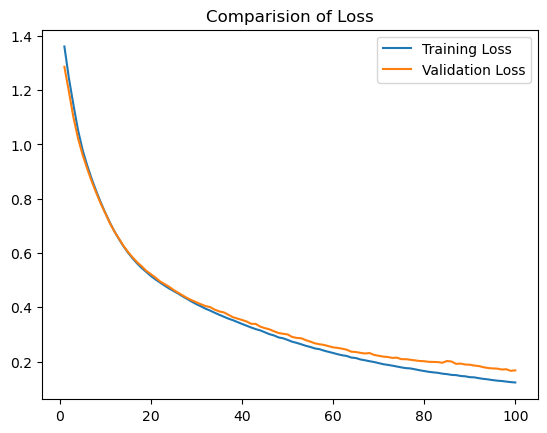

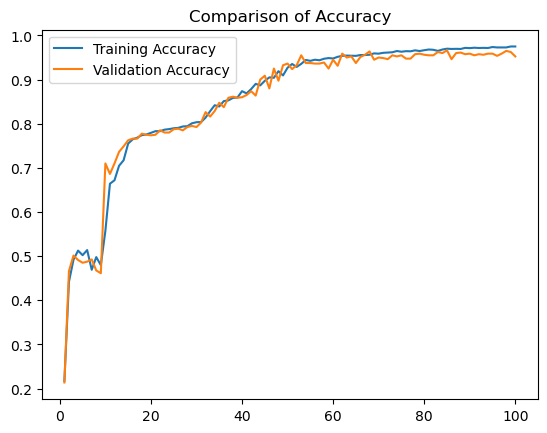

In [13]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = np.arange(1,len(train_loss)+1)
plt.figure()
plt.plot(epochs, train_loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.legend()
plt.title("Comparision of Loss")
plt.show()

plt.figure()
plt.plot(epochs, train_acc, label = "Training Accuracy")
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Comparison of Accuracy")
plt.legend()
plt.show()

In [14]:
test_loss,test_acc = model.evaluate(test_data, test_labels)
print(test_acc)

50/50 [==============================] - 0s 1ms/step - loss: 0.1031 - accuracy: 0.9844
0.984375


In [15]:
prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))
    

50/50 [==============================] - 0s 1ms/step


In [16]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'Normal'),
  Text(1.5, 0, 'ball'),
  Text(2.5, 0, 'inner'),
  Text(3.5, 0, 'outer')])

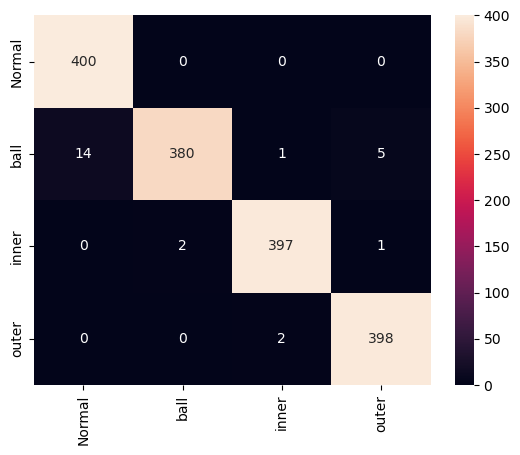

In [17]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels)
plt.xticks(rotation = 90)